In [1]:
#######    
### This function prints off the most likely predicted 
### channels for each of the cells in our dataset
#######

#######    
### Load the Model Parts
#######

import argparse

import SimpleLogger as SimpleLogger

import importlib
import numpy as np

import os
import pickle

import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.utils

#have to do this import to be able to use pyplot in the docker image
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from IPython import display
import time
from model_utils import set_gpu_recursive, load_model, save_state, save_progress, get_latent_embeddings, maybe_save

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

model_dir = './test_aaegan/aaegan3Dv5_128D/struct_model' 

# logger_file = '{0}/logger_tmp.pkl'.format(model_dir)
opt = pickle.load( open( '{0}/opt.pkl'.format(model_dir), "rb" ) )

print(opt)

DP = importlib.import_module("data_providers." + opt.dataProvider)
model_provider = importlib.import_module("models." + opt.model_name)
train_module = importlib.import_module("train_modules." + opt.train_module)

torch.manual_seed(opt.myseed)
torch.cuda.manual_seed(opt.myseed)
np.random.seed(opt.myseed)

if not os.path.exists(opt.save_dir):
    os.makedirs(opt.save_dir)
    
if opt.nepochs_pt2 == -1:
    opt.nepochs_pt2 = opt.nepochs

opts = {}
opts['verbose'] = True
opts['pattern'] = '*.tif_flat.png'
opts['out_size'] = [opt.imsize, opt.imsize]

data_path = './data_{0}x{1}.pyt'.format(str(opts['out_size'][0]), str(opts['out_size'][1]))
if os.path.exists(data_path):
    dp = torch.load(data_path)
else:
    dp = DP.DataProvider(opt.imdir, opts)
    torch.save(dp, data_path)
    
if opt.ndat == -1:
    opt.ndat = dp.get_n_dat('train')    

iters_per_epoch = np.ceil(opt.ndat/opt.batch_size)    
            
#######    
### Load REFERENCE MODEL
#######

embeddings_path = opt.save_parent + os.sep + 'ref_model' + os.sep + 'embeddings.pkl'
if os.path.exists(embeddings_path):
    embeddings = torch.load(embeddings_path)
else:
    embeddings = get_latent_embeddings(models['enc'], dp, opt)
    torch.save(embeddings, embeddings_path)

models = None
optimizers = None
    
def get_ref(self, inds, train_or_test='train'):
    inds = torch.LongTensor(inds)
    return self.embeddings[train_or_test][inds]

dp.embeddings = embeddings

# do this thing to bind the get_ref method to the dataprovider object
import types  
dp.get_ref = types.MethodType(get_ref, dp)
            

opt.channelInds = [0, 1, 2]
dp.opts['channelInds'] = opt.channelInds
opt.nch = len(opt.channelInds)
        
opt.nClasses = dp.get_n_classes()
opt.nRef = opt.nlatentdim

try:
    train_module = None
    train_module = importlib.import_module("train_modules." + opt.train_module)
    train_module = train_module.trainer(dp, opt)
except:
    pass    

models, optimizers, criterions, logger, opt = load_model(model_provider, opt)


enc = models['enc']
dec = models['dec']
enc.train(False)
dec.train(False)



Namespace(Diters=5, DitersAlt=100, batch_size=32, channelInds=[0, 1, 2], channels_pt1=[0, 2], channels_pt2=[0, 1, 2], critRecon='BCELoss', dataProvider='DataProvider3Dh5', decDRatio=0.0001, dtype='float', encDRatio=0.0001, gpu_ids=[0, 1], imdir='/root/results/ipp_dataset_cellnuc_seg_curated_7_24_17', imsize=8, latentDistribution='gaussian', latentSample=<function sampleGaussian at 0x7f322d9e8f28>, lrDec=0.0002, lrDecD=0.0002, lrEnc=0.0002, lrEncD=0.01, model_name='aaegan3Dv5', myseed=0, nClasses=10, nRef=128, nch=3, nclasses=1, ndat=14235, nepochs=200, nepochs_pt2=250, nlatentdim=128, noise=0.01, noise_std=0, optimizer='adam', saveProgressIter=1, saveStateIter=1, save_dir='./test_aaegan/aaegan3Dv5_128D//struct_model', save_parent='./test_aaegan/aaegan3Dv5_128D/', train_module='aaegan_trainv2')
Loading from ./test_aaegan/aaegan3Dv5_128D//struct_model


Dec (
  (fc): Linear (266 -> 2048)
  (main): Sequential (
    (0): BatchNorm3d(1024, eps=1e-05, momentum=0.1, affine=True)
    (1): PReLU (1)
    (2): ConvTranspose3d(1024, 1024, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(0, 1, 0))
    (3): BatchNorm3d(1024, eps=1e-05, momentum=0.1, affine=True)
    (4): PReLU (1)
    (5): ConvTranspose3d(1024, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True)
    (7): PReLU (1)
    (8): ConvTranspose3d(512, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (9): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): PReLU (1)
    (11): ConvTranspose3d(256, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (12): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True)
    (13): PReLU (1)
    (14): ConvTranspose3d(128, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (15): BatchNo

In [11]:
#######    
### Main Loop
#######

import pdb
from aicsimage.io import omeTifWriter
from imgToProjection import imgtoprojection
from IPython.core.display import display
import PIL.Image
import matplotlib.pyplot as plt
import scipy.misc

import pandas as pd

gpu_id = 0

enc = models['enc']
dec = models['dec']
enc.train(False)
dec.train(False)

colormap = 'hsv'
colors = plt.get_cmap(colormap)(np.linspace(0, 1, 4))

px_size = [0.3873, 0.3873, 0.3873]

train_or_test_split = ['train', 'test']

img_paths_all = list()

save_parent = opt.save_dir + os.sep + 'images_out'
save_out_table = save_parent + os.sep + 'list_of_images.csv'

column_names = ['orig', 'recon'] + ['pred_' + name for name in dp.label_names] + ['train_or_test', 'orig_struct', 'img_index']

if not os.path.exists(save_parent):
    os.makedirs(save_parent)

def convert_image(img):
    img = img.data[0].cpu().numpy()
    img = np.transpose(img, (3, 0, 1, 2))
    
    return img

# For train or test
for train_or_test in train_or_test_split:
    ndat = dp.get_n_dat(train_or_test)
    # For each cell in the data split
    for i in range(0, ndat):
        print(str(i) + os.sep + str(ndat))
        
        
        img_index = dp.data[train_or_test]['inds'][i]
        img_class = dp.image_classes[img_index]
        img_name = os.path.basename(dp.get_image_paths([i], train_or_test)[0])[0:-3]
        
        save_dir = save_parent + os.sep + train_or_test + os.sep + img_name
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        #Load the image
        img_in = dp.get_images([i], train_or_test)
        img_in = Variable(img_in.cuda(gpu_id), volatile=True)
        
        #pass forward through the model
        z = enc(img_in)
        img_recon = dec(z)
        
        pred_imgs = list()
        img_paths = list()
        
        #print original images
        img_orig = convert_image(img_in)
        channel_names = ['memb', img_class, 'dna']
        img_name = save_dir + os.sep + 'img' + str(img_index) + '.ome.tif'
        with omeTifWriter.OmeTifWriter(img_name, overwrite_file=True) as w:
            w.save(img_orig, channel_names=channel_names, pixels_physical_size=px_size)
        
        pred_imgs.append(img_orig)
        img_paths.append(img_name)
        
        #print reconstructed images
        img_recon = convert_image(img_recon)
        channel_names_recon = ['memb_recon', img_class + '_recon', 'dna_recon']
        img_name = save_dir + os.sep + 'img' + str(img_index) + '_' + img_class + '-recon.ome.tif'
        with omeTifWriter.OmeTifWriter(img_name, overwrite_file=True) as w:
            w.save(img_recon, channel_names=channel_names_recon, pixels_physical_size=px_size)

        pred_imgs.append(img_recon)
        img_paths.append(img_name)
        channel_names += channel_names_recon
        
        #for each structure type
        for j in range(0, dp.get_n_classes()):
            pred_class_name = dp.label_names[j]
            
            img_name = save_dir + os.sep + 'img' + str(img_index) + '_' + img_class + '-pred_' + pred_class_name + '.ome.tif'
            
            #Set the class label in log(one-hot) form
            z[0].data[0] = torch.zeros(z[0].size()).cuda(gpu_id)
            z[0].data[0][j] = 1
            z[0].data[0] = (z[0].data[0] - 1) * 25
            
            #Reference variable is set as z[1]
            
            #Set the structure variation variable to most probable
            z[-1] = torch.zeros(z[-1].size()).cuda(gpu_id)
            
            #generate image with these settings
            img_recon = dec(z)
            
            #convert the image and get only the GFP channel
            img_recon = convert_image(img_recon)
            img_recon = np.expand_dims(img_recon[:,1,:,:],1)
            
            #save the gfp channel
            with omeTifWriter.OmeTifWriter(img_name, overwrite_file=True) as w:
                w.save(img_recon, channel_names=[pred_class_name + '_pred'], pixels_physical_size=px_size)
            
            channel_names.append(pred_class_name + ' pred')
            
            pred_imgs.append(img_recon)
            img_paths.append(img_name)
            
        img_paths += [train_or_test, img_class, img_index]
        img_paths_all.append(img_paths)
        
        pred_imgs_all = np.concatenate(pred_imgs,1)
        
        # save the all-channels image (orig, recon, and predicted structures)
        img_name = save_dir + os.sep + 'img' + str(img_index) + '_' + img_class + '-pred_all.ome.tif'
        with omeTifWriter.OmeTifWriter(img_name, overwrite_file=True) as w:
                w.save(pred_imgs_all, channel_names=channel_names, pixels_physical_size=px_size)
                
        images_proj = list()
        
        # save flat images
        img_in = convert_image(img_in)
        
        img = np.transpose(img_in, (1,0,2,3))
        img = imgtoprojection(img, proj_all=True, colors = colors, global_adjust=True)
        img = np.transpose(img, (1,2,0))
        
        images_proj.append(img)
        
        img = np.transpose(pred_imgs[1], (1,0,2,3))
        img = imgtoprojection(img, proj_all=True, colors = colors, global_adjust=True)
        img = np.transpose(img, (1,2,0))

        images_proj.append(img)
        
        for j in range(2, len(pred_imgs)):
            img = np.transpose(pred_imgs[j], (1,0,2,3))
            img = imgtoprojection(img, proj_all=True, global_adjust=True)
            img = np.transpose(img, (1,2,0))
            
            images_proj.append(img)
        
        images_proj = np.concatenate(images_proj,1)
        
        scipy.misc.imsave(save_dir + os.sep + 'img' + str(img_index) + '_' + img_class + '-pred_all.png', images_proj)

#save the list of all images
img_paths_all_df = pd.DataFrame(img_paths_all, columns=column_names);
img_paths_all_df.to_csv(save_out_table)


0/14235
1/14235
2/14235
3/14235
4/14235
5/14235
6/14235
7/14235
8/14235
9/14235
10/14235
11/14235
12/14235
13/14235
14/14235
15/14235
16/14235
17/14235
18/14235
19/14235
20/14235
21/14235
22/14235
23/14235
24/14235
25/14235
26/14235
27/14235
28/14235
29/14235
30/14235
31/14235
32/14235
33/14235
34/14235
35/14235
36/14235
37/14235
38/14235
39/14235
40/14235
41/14235
42/14235
43/14235
44/14235
45/14235
46/14235
47/14235
48/14235
49/14235
50/14235
51/14235
52/14235
53/14235
54/14235
55/14235
56/14235
57/14235
58/14235
59/14235
60/14235
61/14235
62/14235
63/14235
64/14235
65/14235
66/14235
67/14235
68/14235
69/14235
70/14235
71/14235
72/14235
73/14235
74/14235
75/14235
76/14235
77/14235
78/14235
79/14235
80/14235
81/14235
82/14235
83/14235
84/14235
85/14235
86/14235
87/14235
88/14235
89/14235
90/14235
91/14235
92/14235
93/14235
94/14235
95/14235
96/14235
97/14235
98/14235
99/14235
100/14235
101/14235
102/14235
103/14235
104/14235
105/14235
106/14235
107/14235
108/14235
109/14235
110/14235


831/14235
832/14235
833/14235
834/14235
835/14235
836/14235
837/14235
838/14235
839/14235
840/14235
841/14235
842/14235
843/14235
844/14235
845/14235
846/14235
847/14235
848/14235
849/14235
850/14235
851/14235
852/14235
853/14235
854/14235
855/14235
856/14235
857/14235
858/14235
859/14235
860/14235
861/14235
862/14235
863/14235
864/14235
865/14235
866/14235
867/14235
868/14235
869/14235
870/14235
871/14235
872/14235
873/14235
874/14235
875/14235
876/14235
877/14235
878/14235
879/14235
880/14235
881/14235
882/14235
883/14235
884/14235
885/14235
886/14235
887/14235
888/14235
889/14235
890/14235
891/14235
892/14235
893/14235
894/14235
895/14235
896/14235
897/14235
898/14235
899/14235
900/14235
901/14235
902/14235
903/14235
904/14235
905/14235
906/14235
907/14235
908/14235
909/14235
910/14235
911/14235
912/14235
913/14235
914/14235
915/14235
916/14235
917/14235
918/14235
919/14235
920/14235
921/14235
922/14235
923/14235
924/14235
925/14235
926/14235
927/14235
928/14235
929/14235
930/14235


1592/14235
1593/14235
1594/14235
1595/14235
1596/14235
1597/14235
1598/14235
1599/14235
1600/14235
1601/14235
1602/14235
1603/14235
1604/14235
1605/14235
1606/14235
1607/14235
1608/14235
1609/14235
1610/14235
1611/14235
1612/14235
1613/14235
1614/14235
1615/14235
1616/14235
1617/14235
1618/14235
1619/14235
1620/14235
1621/14235
1622/14235
1623/14235
1624/14235
1625/14235
1626/14235
1627/14235
1628/14235
1629/14235
1630/14235
1631/14235
1632/14235
1633/14235
1634/14235
1635/14235
1636/14235
1637/14235
1638/14235
1639/14235
1640/14235
1641/14235
1642/14235
1643/14235
1644/14235
1645/14235
1646/14235
1647/14235
1648/14235
1649/14235
1650/14235
1651/14235
1652/14235
1653/14235
1654/14235
1655/14235
1656/14235
1657/14235
1658/14235
1659/14235
1660/14235
1661/14235
1662/14235
1663/14235
1664/14235
1665/14235
1666/14235
1667/14235
1668/14235
1669/14235
1670/14235
1671/14235
1672/14235
1673/14235
1674/14235
1675/14235
1676/14235
1677/14235
1678/14235
1679/14235
1680/14235
1681/14235
1682/14235

2337/14235
2338/14235
2339/14235
2340/14235
2341/14235
2342/14235
2343/14235
2344/14235
2345/14235
2346/14235
2347/14235
2348/14235
2349/14235
2350/14235
2351/14235
2352/14235
2353/14235
2354/14235
2355/14235
2356/14235
2357/14235
2358/14235
2359/14235
2360/14235
2361/14235
2362/14235
2363/14235
2364/14235
2365/14235
2366/14235
2367/14235
2368/14235
2369/14235
2370/14235
2371/14235
2372/14235
2373/14235
2374/14235
2375/14235
2376/14235
2377/14235
2378/14235
2379/14235
2380/14235
2381/14235
2382/14235
2383/14235
2384/14235
2385/14235
2386/14235
2387/14235
2388/14235
2389/14235
2390/14235
2391/14235
2392/14235
2393/14235
2394/14235
2395/14235
2396/14235
2397/14235
2398/14235
2399/14235
2400/14235
2401/14235
2402/14235
2403/14235
2404/14235
2405/14235
2406/14235
2407/14235
2408/14235
2409/14235
2410/14235
2411/14235
2412/14235
2413/14235
2414/14235
2415/14235
2416/14235
2417/14235
2418/14235
2419/14235
2420/14235
2421/14235
2422/14235
2423/14235
2424/14235
2425/14235
2426/14235
2427/14235

3082/14235
3083/14235
3084/14235
3085/14235
3086/14235
3087/14235
3088/14235
3089/14235
3090/14235
3091/14235
3092/14235
3093/14235
3094/14235
3095/14235
3096/14235
3097/14235
3098/14235
3099/14235
3100/14235
3101/14235
3102/14235
3103/14235
3104/14235
3105/14235
3106/14235
3107/14235
3108/14235
3109/14235
3110/14235
3111/14235
3112/14235
3113/14235
3114/14235
3115/14235
3116/14235
3117/14235
3118/14235
3119/14235
3120/14235
3121/14235
3122/14235
3123/14235
3124/14235
3125/14235
3126/14235
3127/14235
3128/14235
3129/14235
3130/14235
3131/14235
3132/14235
3133/14235
3134/14235
3135/14235
3136/14235
3137/14235
3138/14235
3139/14235
3140/14235
3141/14235
3142/14235
3143/14235
3144/14235
3145/14235
3146/14235
3147/14235
3148/14235
3149/14235
3150/14235
3151/14235
3152/14235
3153/14235
3154/14235
3155/14235
3156/14235
3157/14235
3158/14235
3159/14235
3160/14235
3161/14235
3162/14235
3163/14235
3164/14235
3165/14235
3166/14235
3167/14235
3168/14235
3169/14235
3170/14235
3171/14235
3172/14235

3827/14235
3828/14235
3829/14235
3830/14235
3831/14235
3832/14235
3833/14235
3834/14235
3835/14235
3836/14235
3837/14235
3838/14235
3839/14235
3840/14235
3841/14235
3842/14235
3843/14235
3844/14235
3845/14235
3846/14235
3847/14235
3848/14235
3849/14235
3850/14235
3851/14235
3852/14235
3853/14235
3854/14235
3855/14235
3856/14235
3857/14235
3858/14235
3859/14235
3860/14235
3861/14235
3862/14235
3863/14235
3864/14235
3865/14235
3866/14235
3867/14235
3868/14235
3869/14235
3870/14235
3871/14235
3872/14235
3873/14235
3874/14235
3875/14235
3876/14235
3877/14235
3878/14235
3879/14235
3880/14235
3881/14235
3882/14235
3883/14235
3884/14235
3885/14235
3886/14235
3887/14235
3888/14235
3889/14235
3890/14235
3891/14235
3892/14235
3893/14235
3894/14235
3895/14235
3896/14235
3897/14235
3898/14235
3899/14235
3900/14235
3901/14235
3902/14235
3903/14235
3904/14235
3905/14235
3906/14235
3907/14235
3908/14235
3909/14235
3910/14235
3911/14235
3912/14235
3913/14235
3914/14235
3915/14235
3916/14235
3917/14235

4572/14235
4573/14235
4574/14235
4575/14235
4576/14235
4577/14235
4578/14235
4579/14235
4580/14235
4581/14235
4582/14235
4583/14235
4584/14235
4585/14235
4586/14235
4587/14235
4588/14235
4589/14235
4590/14235
4591/14235
4592/14235
4593/14235
4594/14235
4595/14235
4596/14235
4597/14235
4598/14235
4599/14235
4600/14235
4601/14235
4602/14235
4603/14235
4604/14235
4605/14235
4606/14235
4607/14235
4608/14235
4609/14235
4610/14235
4611/14235
4612/14235
4613/14235
4614/14235
4615/14235
4616/14235
4617/14235
4618/14235
4619/14235
4620/14235
4621/14235
4622/14235
4623/14235
4624/14235
4625/14235
4626/14235
4627/14235
4628/14235
4629/14235
4630/14235
4631/14235
4632/14235
4633/14235
4634/14235
4635/14235
4636/14235
4637/14235
4638/14235
4639/14235
4640/14235
4641/14235
4642/14235
4643/14235
4644/14235
4645/14235
4646/14235
4647/14235
4648/14235
4649/14235
4650/14235
4651/14235
4652/14235
4653/14235
4654/14235
4655/14235
4656/14235
4657/14235
4658/14235
4659/14235
4660/14235
4661/14235
4662/14235

5317/14235
5318/14235
5319/14235
5320/14235
5321/14235
5322/14235
5323/14235
5324/14235
5325/14235
5326/14235
5327/14235
5328/14235
5329/14235
5330/14235
5331/14235
5332/14235
5333/14235
5334/14235
5335/14235
5336/14235
5337/14235
5338/14235
5339/14235
5340/14235
5341/14235
5342/14235
5343/14235
5344/14235
5345/14235
5346/14235
5347/14235
5348/14235
5349/14235
5350/14235
5351/14235
5352/14235
5353/14235
5354/14235
5355/14235
5356/14235
5357/14235
5358/14235
5359/14235
5360/14235
5361/14235
5362/14235
5363/14235
5364/14235
5365/14235
5366/14235
5367/14235
5368/14235
5369/14235
5370/14235
5371/14235
5372/14235
5373/14235
5374/14235
5375/14235
5376/14235
5377/14235
5378/14235
5379/14235
5380/14235
5381/14235
5382/14235
5383/14235
5384/14235
5385/14235
5386/14235
5387/14235
5388/14235
5389/14235
5390/14235
5391/14235
5392/14235
5393/14235
5394/14235
5395/14235
5396/14235
5397/14235
5398/14235
5399/14235
5400/14235
5401/14235
5402/14235
5403/14235
5404/14235
5405/14235
5406/14235
5407/14235

6062/14235
6063/14235
6064/14235
6065/14235
6066/14235
6067/14235
6068/14235
6069/14235
6070/14235
6071/14235
6072/14235
6073/14235
6074/14235
6075/14235
6076/14235
6077/14235
6078/14235
6079/14235
6080/14235
6081/14235
6082/14235
6083/14235
6084/14235
6085/14235
6086/14235
6087/14235
6088/14235
6089/14235
6090/14235
6091/14235
6092/14235
6093/14235
6094/14235
6095/14235
6096/14235
6097/14235
6098/14235
6099/14235
6100/14235
6101/14235
6102/14235
6103/14235
6104/14235
6105/14235
6106/14235
6107/14235
6108/14235
6109/14235
6110/14235
6111/14235
6112/14235
6113/14235
6114/14235
6115/14235
6116/14235
6117/14235
6118/14235
6119/14235
6120/14235
6121/14235
6122/14235
6123/14235
6124/14235
6125/14235
6126/14235
6127/14235
6128/14235
6129/14235
6130/14235
6131/14235
6132/14235
6133/14235
6134/14235
6135/14235
6136/14235
6137/14235
6138/14235
6139/14235
6140/14235
6141/14235
6142/14235
6143/14235
6144/14235
6145/14235
6146/14235
6147/14235
6148/14235
6149/14235
6150/14235
6151/14235
6152/14235

6807/14235
6808/14235
6809/14235
6810/14235
6811/14235
6812/14235
6813/14235
6814/14235
6815/14235
6816/14235
6817/14235
6818/14235
6819/14235
6820/14235
6821/14235
6822/14235
6823/14235
6824/14235
6825/14235
6826/14235
6827/14235
6828/14235
6829/14235
6830/14235
6831/14235
6832/14235
6833/14235
6834/14235
6835/14235
6836/14235
6837/14235
6838/14235
6839/14235
6840/14235
6841/14235
6842/14235
6843/14235
6844/14235
6845/14235
6846/14235
6847/14235
6848/14235
6849/14235
6850/14235
6851/14235
6852/14235
6853/14235
6854/14235
6855/14235
6856/14235
6857/14235
6858/14235
6859/14235
6860/14235
6861/14235
6862/14235
6863/14235
6864/14235
6865/14235
6866/14235
6867/14235
6868/14235
6869/14235
6870/14235
6871/14235
6872/14235
6873/14235
6874/14235
6875/14235
6876/14235
6877/14235
6878/14235
6879/14235
6880/14235
6881/14235
6882/14235
6883/14235
6884/14235
6885/14235
6886/14235
6887/14235
6888/14235
6889/14235
6890/14235
6891/14235
6892/14235
6893/14235
6894/14235
6895/14235
6896/14235
6897/14235

7552/14235
7553/14235
7554/14235
7555/14235
7556/14235
7557/14235
7558/14235
7559/14235
7560/14235
7561/14235
7562/14235
7563/14235
7564/14235
7565/14235
7566/14235
7567/14235
7568/14235
7569/14235
7570/14235
7571/14235
7572/14235
7573/14235
7574/14235
7575/14235
7576/14235
7577/14235
7578/14235
7579/14235
7580/14235
7581/14235
7582/14235
7583/14235
7584/14235
7585/14235
7586/14235
7587/14235
7588/14235
7589/14235
7590/14235
7591/14235
7592/14235
7593/14235
7594/14235
7595/14235
7596/14235
7597/14235
7598/14235
7599/14235
7600/14235
7601/14235
7602/14235
7603/14235
7604/14235
7605/14235
7606/14235
7607/14235
7608/14235
7609/14235
7610/14235
7611/14235
7612/14235
7613/14235
7614/14235
7615/14235
7616/14235
7617/14235
7618/14235
7619/14235
7620/14235
7621/14235
7622/14235
7623/14235
7624/14235
7625/14235
7626/14235
7627/14235
7628/14235
7629/14235
7630/14235
7631/14235
7632/14235
7633/14235
7634/14235
7635/14235
7636/14235
7637/14235
7638/14235
7639/14235
7640/14235
7641/14235
7642/14235

8297/14235
8298/14235
8299/14235
8300/14235
8301/14235
8302/14235
8303/14235
8304/14235
8305/14235
8306/14235
8307/14235
8308/14235
8309/14235
8310/14235
8311/14235
8312/14235
8313/14235
8314/14235
8315/14235
8316/14235
8317/14235
8318/14235
8319/14235
8320/14235
8321/14235
8322/14235
8323/14235
8324/14235
8325/14235
8326/14235
8327/14235
8328/14235
8329/14235
8330/14235
8331/14235
8332/14235
8333/14235
8334/14235
8335/14235
8336/14235
8337/14235
8338/14235
8339/14235
8340/14235
8341/14235
8342/14235
8343/14235
8344/14235
8345/14235
8346/14235
8347/14235
8348/14235
8349/14235
8350/14235
8351/14235
8352/14235
8353/14235
8354/14235
8355/14235
8356/14235
8357/14235
8358/14235
8359/14235
8360/14235
8361/14235
8362/14235
8363/14235
8364/14235
8365/14235
8366/14235
8367/14235
8368/14235
8369/14235
8370/14235
8371/14235
8372/14235
8373/14235
8374/14235
8375/14235
8376/14235
8377/14235
8378/14235
8379/14235
8380/14235
8381/14235
8382/14235
8383/14235
8384/14235
8385/14235
8386/14235
8387/14235

9042/14235
9043/14235
9044/14235
9045/14235
9046/14235
9047/14235
9048/14235
9049/14235
9050/14235
9051/14235
9052/14235
9053/14235
9054/14235
9055/14235
9056/14235
9057/14235
9058/14235
9059/14235
9060/14235
9061/14235
9062/14235
9063/14235
9064/14235
9065/14235
9066/14235
9067/14235
9068/14235
9069/14235
9070/14235
9071/14235
9072/14235
9073/14235
9074/14235
9075/14235
9076/14235
9077/14235
9078/14235
9079/14235
9080/14235
9081/14235
9082/14235
9083/14235
9084/14235
9085/14235
9086/14235
9087/14235
9088/14235
9089/14235
9090/14235
9091/14235
9092/14235
9093/14235
9094/14235
9095/14235
9096/14235
9097/14235
9098/14235
9099/14235
9100/14235
9101/14235
9102/14235
9103/14235
9104/14235
9105/14235
9106/14235
9107/14235
9108/14235
9109/14235
9110/14235
9111/14235
9112/14235
9113/14235
9114/14235
9115/14235
9116/14235
9117/14235
9118/14235
9119/14235
9120/14235
9121/14235
9122/14235
9123/14235
9124/14235
9125/14235
9126/14235
9127/14235
9128/14235
9129/14235
9130/14235
9131/14235
9132/14235

9787/14235
9788/14235
9789/14235
9790/14235
9791/14235
9792/14235
9793/14235
9794/14235
9795/14235
9796/14235
9797/14235
9798/14235
9799/14235
9800/14235
9801/14235
9802/14235
9803/14235
9804/14235
9805/14235
9806/14235
9807/14235
9808/14235
9809/14235
9810/14235
9811/14235
9812/14235
9813/14235
9814/14235
9815/14235
9816/14235
9817/14235
9818/14235
9819/14235
9820/14235
9821/14235
9822/14235
9823/14235
9824/14235
9825/14235
9826/14235
9827/14235
9828/14235
9829/14235
9830/14235
9831/14235
9832/14235
9833/14235
9834/14235
9835/14235
9836/14235
9837/14235
9838/14235
9839/14235
9840/14235
9841/14235
9842/14235
9843/14235
9844/14235
9845/14235
9846/14235
9847/14235
9848/14235
9849/14235
9850/14235
9851/14235
9852/14235
9853/14235
9854/14235
9855/14235
9856/14235
9857/14235
9858/14235
9859/14235
9860/14235
9861/14235
9862/14235
9863/14235
9864/14235
9865/14235
9866/14235
9867/14235
9868/14235
9869/14235
9870/14235
9871/14235
9872/14235
9873/14235
9874/14235
9875/14235
9876/14235
9877/14235

10488/14235
10489/14235
10490/14235
10491/14235
10492/14235
10493/14235
10494/14235
10495/14235
10496/14235
10497/14235
10498/14235
10499/14235
10500/14235
10501/14235
10502/14235
10503/14235
10504/14235
10505/14235
10506/14235
10507/14235
10508/14235
10509/14235
10510/14235
10511/14235
10512/14235
10513/14235
10514/14235
10515/14235
10516/14235
10517/14235
10518/14235
10519/14235
10520/14235
10521/14235
10522/14235
10523/14235
10524/14235
10525/14235
10526/14235
10527/14235
10528/14235
10529/14235
10530/14235
10531/14235
10532/14235
10533/14235
10534/14235
10535/14235
10536/14235
10537/14235
10538/14235
10539/14235
10540/14235
10541/14235
10542/14235
10543/14235
10544/14235
10545/14235
10546/14235
10547/14235
10548/14235
10549/14235
10550/14235
10551/14235
10552/14235
10553/14235
10554/14235
10555/14235
10556/14235
10557/14235
10558/14235
10559/14235
10560/14235
10561/14235
10562/14235
10563/14235
10564/14235
10565/14235
10566/14235
10567/14235
10568/14235
10569/14235
10570/14235
1057

11171/14235
11172/14235
11173/14235
11174/14235
11175/14235
11176/14235
11177/14235
11178/14235
11179/14235
11180/14235
11181/14235
11182/14235
11183/14235
11184/14235
11185/14235
11186/14235
11187/14235
11188/14235
11189/14235
11190/14235
11191/14235
11192/14235
11193/14235
11194/14235
11195/14235
11196/14235
11197/14235
11198/14235
11199/14235
11200/14235
11201/14235
11202/14235
11203/14235
11204/14235
11205/14235
11206/14235
11207/14235
11208/14235
11209/14235
11210/14235
11211/14235
11212/14235
11213/14235
11214/14235
11215/14235
11216/14235
11217/14235
11218/14235
11219/14235
11220/14235
11221/14235
11222/14235
11223/14235
11224/14235
11225/14235
11226/14235
11227/14235
11228/14235
11229/14235
11230/14235
11231/14235
11232/14235
11233/14235
11234/14235
11235/14235
11236/14235
11237/14235
11238/14235
11239/14235
11240/14235
11241/14235
11242/14235
11243/14235
11244/14235
11245/14235
11246/14235
11247/14235
11248/14235
11249/14235
11250/14235
11251/14235
11252/14235
11253/14235
1125

11854/14235
11855/14235
11856/14235
11857/14235
11858/14235
11859/14235
11860/14235
11861/14235
11862/14235
11863/14235
11864/14235
11865/14235
11866/14235
11867/14235
11868/14235
11869/14235
11870/14235
11871/14235
11872/14235
11873/14235
11874/14235
11875/14235
11876/14235
11877/14235
11878/14235
11879/14235
11880/14235
11881/14235
11882/14235
11883/14235
11884/14235
11885/14235
11886/14235
11887/14235
11888/14235
11889/14235
11890/14235
11891/14235
11892/14235
11893/14235
11894/14235
11895/14235
11896/14235
11897/14235
11898/14235
11899/14235
11900/14235
11901/14235
11902/14235
11903/14235
11904/14235
11905/14235
11906/14235
11907/14235
11908/14235
11909/14235
11910/14235
11911/14235
11912/14235
11913/14235
11914/14235
11915/14235
11916/14235
11917/14235
11918/14235
11919/14235
11920/14235
11921/14235
11922/14235
11923/14235
11924/14235
11925/14235
11926/14235
11927/14235
11928/14235
11929/14235
11930/14235
11931/14235
11932/14235
11933/14235
11934/14235
11935/14235
11936/14235
1193

12537/14235
12538/14235
12539/14235
12540/14235
12541/14235
12542/14235
12543/14235
12544/14235
12545/14235
12546/14235
12547/14235
12548/14235
12549/14235
12550/14235
12551/14235
12552/14235
12553/14235
12554/14235
12555/14235
12556/14235
12557/14235
12558/14235
12559/14235
12560/14235
12561/14235
12562/14235
12563/14235
12564/14235
12565/14235
12566/14235
12567/14235
12568/14235
12569/14235
12570/14235
12571/14235
12572/14235
12573/14235
12574/14235
12575/14235
12576/14235
12577/14235
12578/14235
12579/14235
12580/14235
12581/14235
12582/14235
12583/14235
12584/14235
12585/14235
12586/14235
12587/14235
12588/14235
12589/14235
12590/14235
12591/14235
12592/14235
12593/14235
12594/14235
12595/14235
12596/14235
12597/14235
12598/14235
12599/14235
12600/14235
12601/14235
12602/14235
12603/14235
12604/14235
12605/14235
12606/14235
12607/14235
12608/14235
12609/14235
12610/14235
12611/14235
12612/14235
12613/14235
12614/14235
12615/14235
12616/14235
12617/14235
12618/14235
12619/14235
1262

13220/14235
13221/14235
13222/14235
13223/14235
13224/14235
13225/14235
13226/14235
13227/14235
13228/14235
13229/14235
13230/14235
13231/14235
13232/14235
13233/14235
13234/14235
13235/14235
13236/14235
13237/14235
13238/14235
13239/14235
13240/14235
13241/14235
13242/14235
13243/14235
13244/14235
13245/14235
13246/14235
13247/14235
13248/14235
13249/14235
13250/14235
13251/14235
13252/14235
13253/14235
13254/14235
13255/14235
13256/14235
13257/14235
13258/14235
13259/14235
13260/14235
13261/14235
13262/14235
13263/14235
13264/14235
13265/14235
13266/14235
13267/14235
13268/14235
13269/14235
13270/14235
13271/14235
13272/14235
13273/14235
13274/14235
13275/14235
13276/14235
13277/14235
13278/14235
13279/14235
13280/14235
13281/14235
13282/14235
13283/14235
13284/14235
13285/14235
13286/14235
13287/14235
13288/14235
13289/14235
13290/14235
13291/14235
13292/14235
13293/14235
13294/14235
13295/14235
13296/14235
13297/14235
13298/14235
13299/14235
13300/14235
13301/14235
13302/14235
1330

13903/14235
13904/14235
13905/14235
13906/14235
13907/14235
13908/14235
13909/14235
13910/14235
13911/14235
13912/14235
13913/14235
13914/14235
13915/14235
13916/14235
13917/14235
13918/14235
13919/14235
13920/14235
13921/14235
13922/14235
13923/14235
13924/14235
13925/14235
13926/14235
13927/14235
13928/14235
13929/14235
13930/14235
13931/14235
13932/14235
13933/14235
13934/14235
13935/14235
13936/14235
13937/14235
13938/14235
13939/14235
13940/14235
13941/14235
13942/14235
13943/14235
13944/14235
13945/14235
13946/14235
13947/14235
13948/14235
13949/14235
13950/14235
13951/14235
13952/14235
13953/14235
13954/14235
13955/14235
13956/14235
13957/14235
13958/14235
13959/14235
13960/14235
13961/14235
13962/14235
13963/14235
13964/14235
13965/14235
13966/14235
13967/14235
13968/14235
13969/14235
13970/14235
13971/14235
13972/14235
13973/14235
13974/14235
13975/14235
13976/14235
13977/14235
13978/14235
13979/14235
13980/14235
13981/14235
13982/14235
13983/14235
13984/14235
13985/14235
1398

480/1592
481/1592
482/1592
483/1592
484/1592
485/1592
486/1592
487/1592
488/1592
489/1592
490/1592
491/1592
492/1592
493/1592
494/1592
495/1592
496/1592
497/1592
498/1592
499/1592
500/1592
501/1592
502/1592
503/1592
504/1592
505/1592
506/1592
507/1592
508/1592
509/1592
510/1592
511/1592
512/1592
513/1592
514/1592
515/1592
516/1592
517/1592
518/1592
519/1592
520/1592
521/1592
522/1592
523/1592
524/1592
525/1592
526/1592
527/1592
528/1592
529/1592
530/1592
531/1592
532/1592
533/1592
534/1592
535/1592
536/1592
537/1592
538/1592
539/1592
540/1592
541/1592
542/1592
543/1592
544/1592
545/1592
546/1592
547/1592
548/1592
549/1592
550/1592
551/1592
552/1592
553/1592
554/1592
555/1592
556/1592
557/1592
558/1592
559/1592
560/1592
561/1592
562/1592
563/1592
564/1592
565/1592
566/1592
567/1592
568/1592
569/1592
570/1592
571/1592
572/1592
573/1592
574/1592
575/1592
576/1592
577/1592
578/1592
579/1592
580/1592
581/1592
582/1592
583/1592
584/1592
585/1592
586/1592
587/1592
588/1592
589/1592
590/1592
5

1352/1592
1353/1592
1354/1592
1355/1592
1356/1592
1357/1592
1358/1592
1359/1592
1360/1592
1361/1592
1362/1592
1363/1592
1364/1592
1365/1592
1366/1592
1367/1592
1368/1592
1369/1592
1370/1592
1371/1592
1372/1592
1373/1592
1374/1592
1375/1592
1376/1592
1377/1592
1378/1592
1379/1592
1380/1592
1381/1592
1382/1592
1383/1592
1384/1592
1385/1592
1386/1592
1387/1592
1388/1592
1389/1592
1390/1592
1391/1592
1392/1592
1393/1592
1394/1592
1395/1592
1396/1592
1397/1592
1398/1592
1399/1592
1400/1592
1401/1592
1402/1592
1403/1592
1404/1592
1405/1592
1406/1592
1407/1592
1408/1592
1409/1592
1410/1592
1411/1592
1412/1592
1413/1592
1414/1592
1415/1592
1416/1592
1417/1592
1418/1592
1419/1592
1420/1592
1421/1592
1422/1592
1423/1592
1424/1592
1425/1592
1426/1592
1427/1592
1428/1592
1429/1592
1430/1592
1431/1592
1432/1592
1433/1592
1434/1592
1435/1592
1436/1592
1437/1592
1438/1592
1439/1592
1440/1592
1441/1592
1442/1592
1443/1592
1444/1592
1445/1592
1446/1592
1447/1592
1448/1592
1449/1592
1450/1592
1451/1592


In [222]:
# print(img2.shape)
# print(img2[:,(cell_w*0):(cell_w*1),[0,2]].shape)
# print(img2[:,(cell_w*(i+2)):(cell_w*(i+3)),[0,2]])

# print(i)

print(len(img_tmp))

10


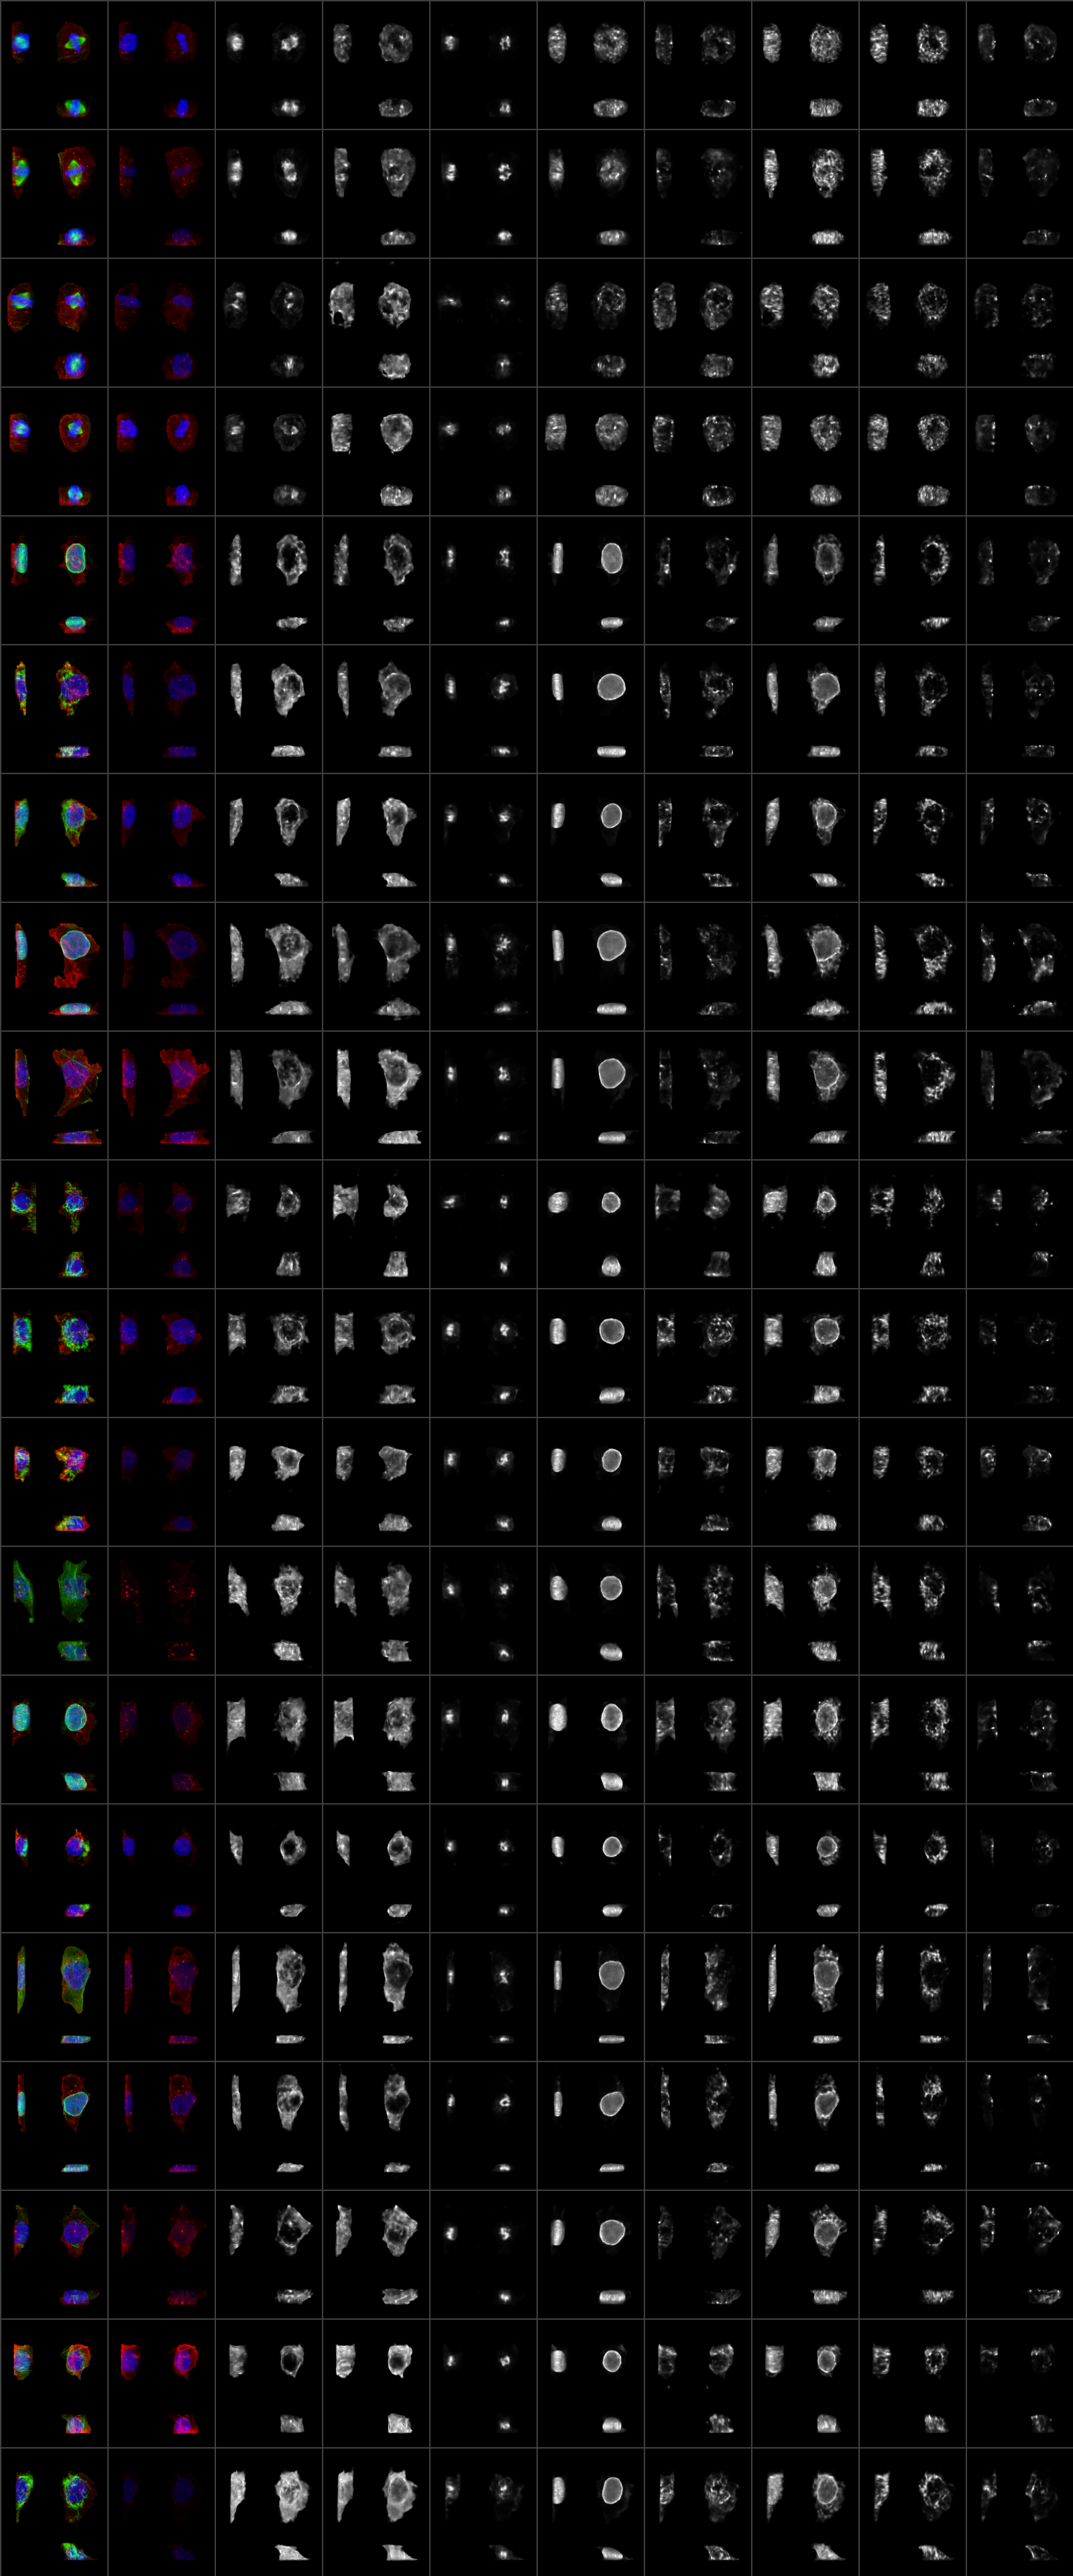

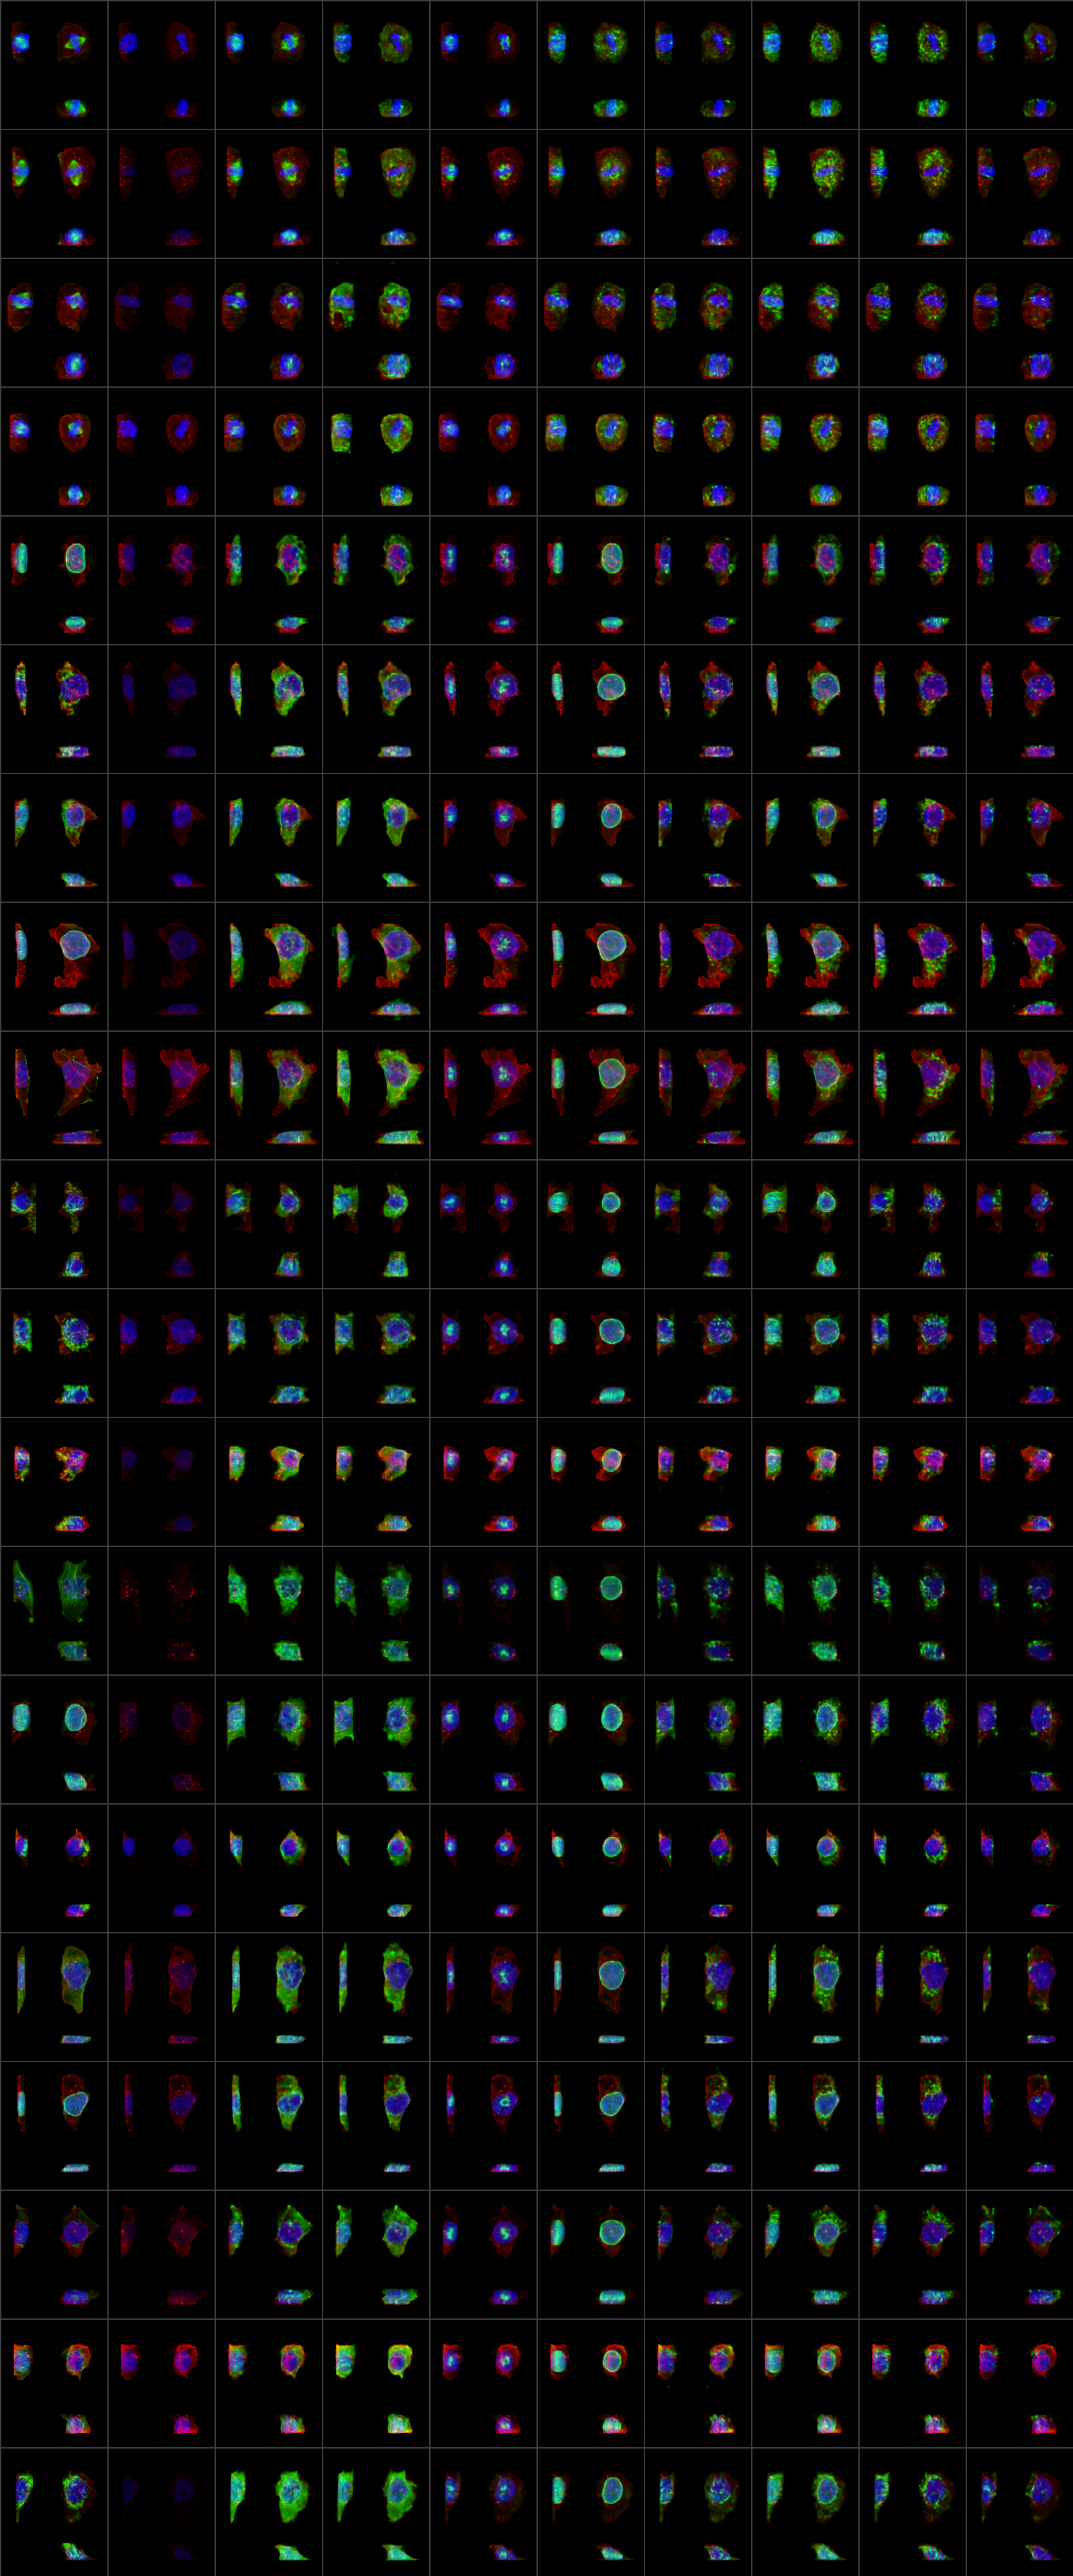

In [229]:
# Print off selected images and some random ones
import scipy.misc as misc
import PIL.Image
from IPython.core.display import display


keep_inds = [10355, 10371, 10791, 11565]

nwide = 20;
nmore = nwide - len(keep_inds)

ustruct = img_paths_all_df['orig_struct'].unique()
ustruct = np.sort(ustruct)

ustruct = ['Alpha tubulin', 'Beta actin', 'Fibrillarin',
 'Lamin B1', 'Myosin IIB', 'Sec61 beta', 'Tom20', 'ZO1']

npatterns = 10

cell_w = 160
cell_h = 192
border_w = 2
border_color = 64


train_inds = np.where(img_paths_all_df['train_or_test'] == 'test')
train_img_inds = img_paths_all_df.iloc[train_inds]['img_index'].values

np.random.shuffle(train_img_inds)

inds = keep_inds + list(train_img_inds[0:nmore])

imgs_white = list()
imgs_rgb = list()

for ind in inds:
    row = img_paths_all_df[img_paths_all_df['img_index'] == ind]
    im_path = row['recon'].values[0][0:-13] + 'pred_all.png'
    img = misc.imread(im_path)
    
#     img[:,(160*1):(160*2),0] = 0
    img[:,(cell_w*1):(cell_w*2),:] = img[:,(cell_w*0):(cell_w*1),:]
    img[:,(cell_w*1):(cell_w*2),1] = 0
    
    img_tmp = list()
    
    for i in range(0, npatterns+2):
        if i == 2 or i == 5: continue
        img_cell = img[:, (160*i):(160*(i+1)), :];
        
        
        for j in range(0, img_cell.shape[2]):
            if i != 1 and j != 1:
                img_cell[:,:,j] = (img_cell[:,:,j]+0.00001)/(np.max(img_cell[:,:,j])+0.00001) * 255

        img_cell[:, 0:border_w, :] = border_color
        img_cell[0:border_w, :, :] = border_color
        

        
        img_tmp.append(img_cell)
        
    img = np.concatenate(img_tmp, axis=1)
    
    imgs_white.append(img)
    

    img2 = np.copy(img)
    for i in range(0,len(img_tmp)-2):
        img2[:,(cell_w*(i+2)):(cell_w*(i+3)),[0,2]] = img2[:,(cell_w*0):(cell_w*1),[0,2]]
    
    
    imgs_rgb.append(img2)


# img_paths_all_df.iloc[np.where(img_paths_all_df['img_index'] == 0)[0]]['orig'].values

img_out_white = np.concatenate(imgs_white, axis=0)
img_out_rgb = np.concatenate(imgs_rgb, axis=0)

misc.imsave(save_parent + os.sep + 'train_white.png', img_out_white)
misc.imsave(save_parent + os.sep + 'train_rgb.png', img_out_rgb)

display(PIL.Image.fromarray(img_out_white))
display(PIL.Image.fromarray(img_out_rgb))

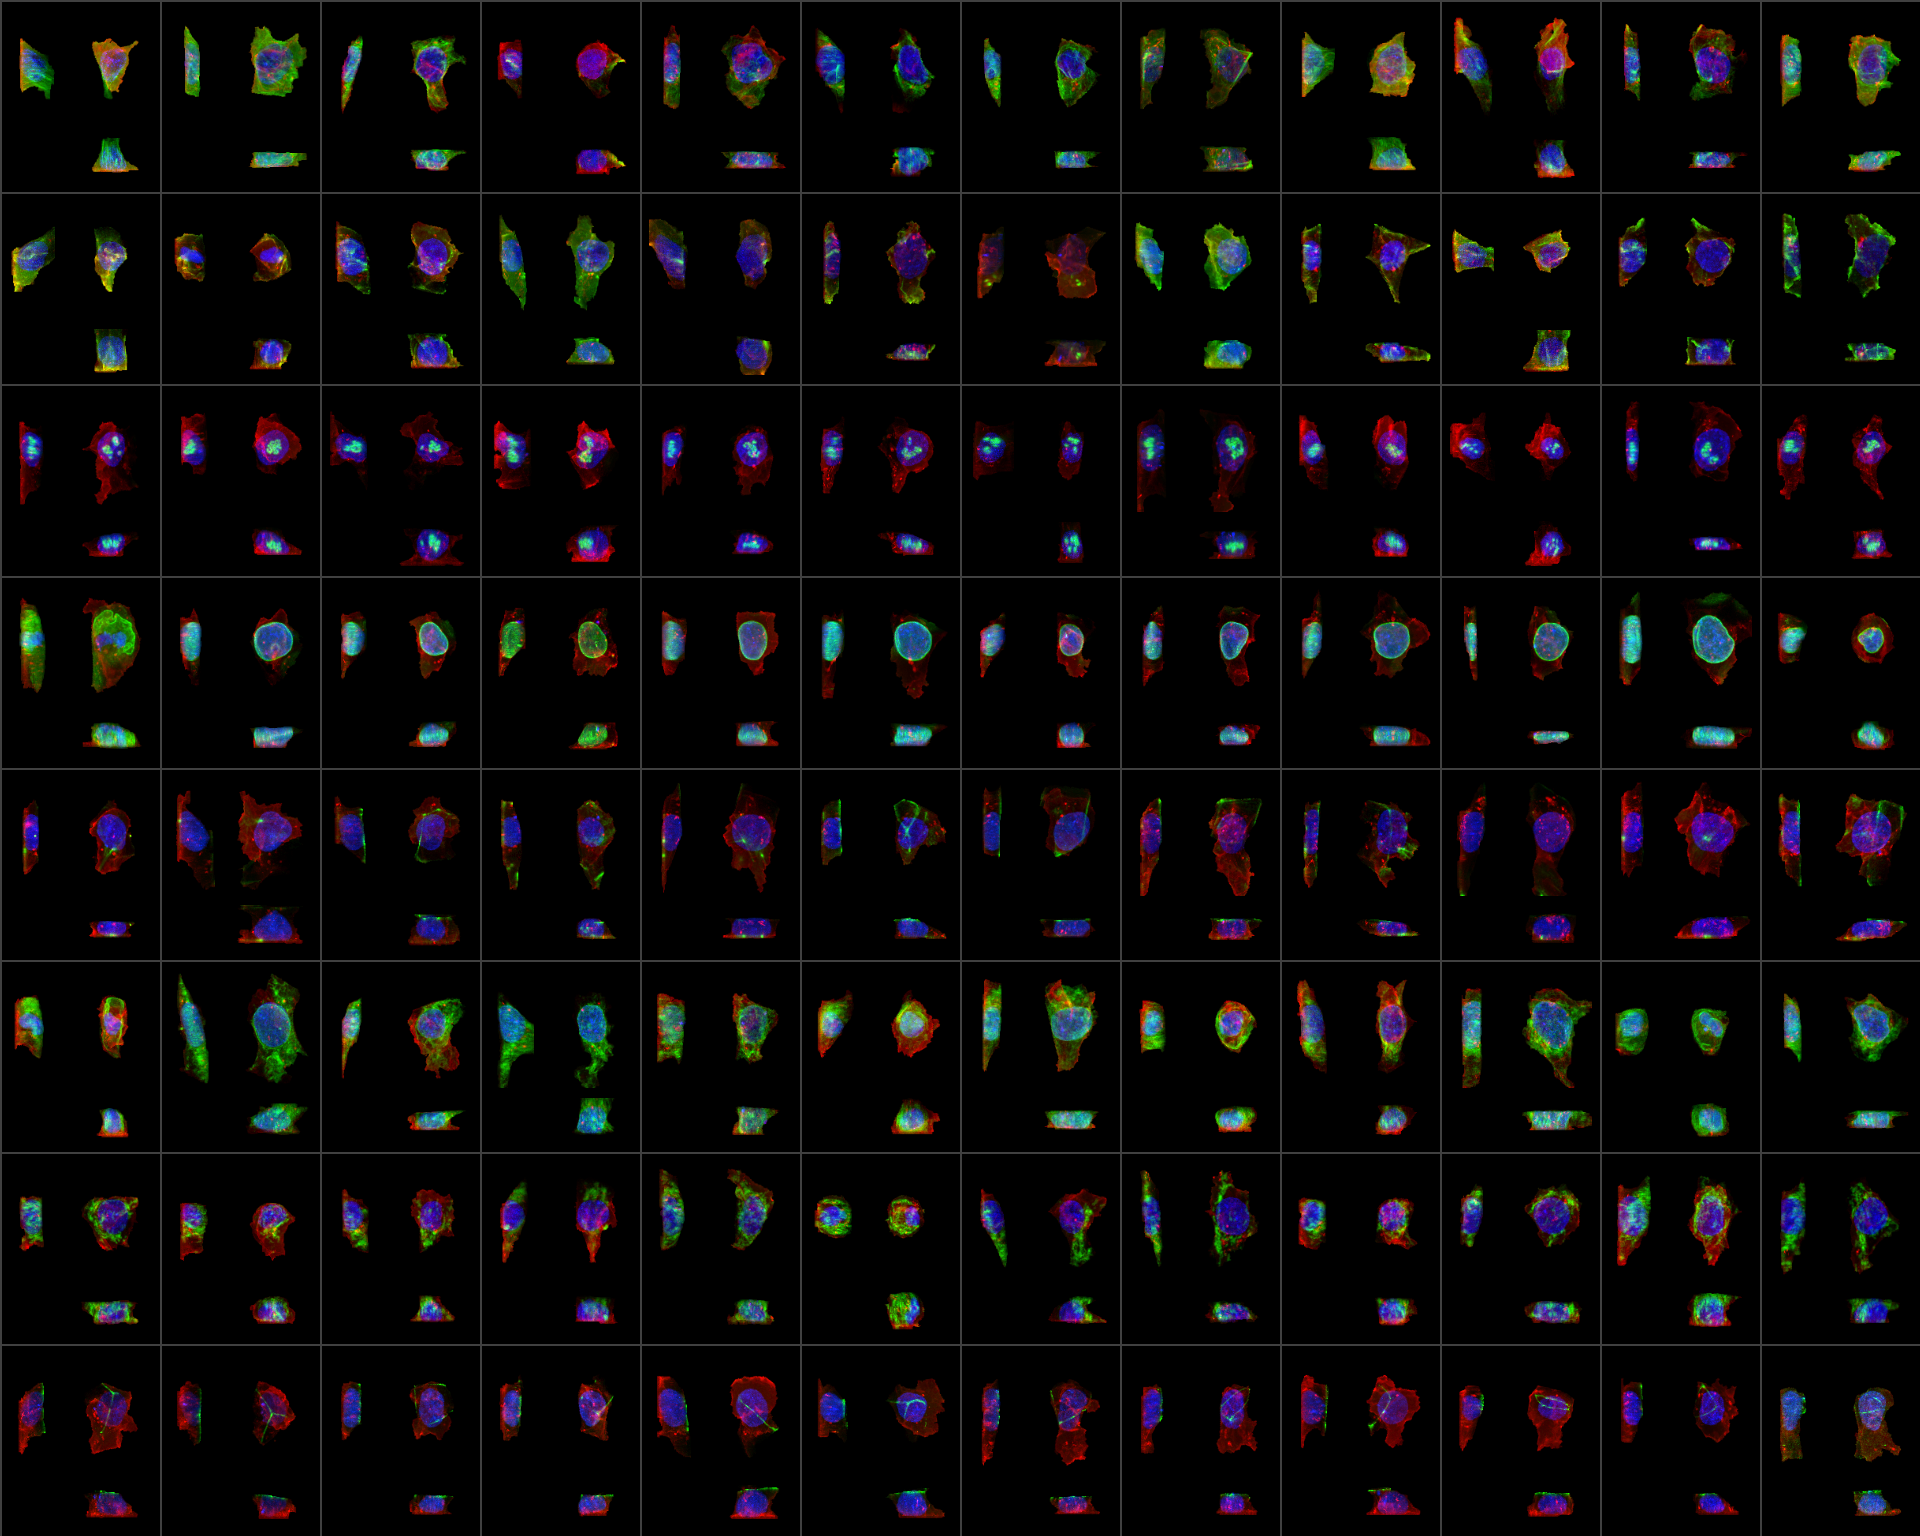

['Alpha tubulin', 'Beta actin', 'Fibrillarin', 'Lamin B1', 'Myosin IIB', 'Sec61 beta', 'Tom20', 'ZO1']


In [206]:
nwide = 12

imgs_all = list()

npatterns = len(ustruct)

for struct in ustruct:
    rows = img_paths_all_df[img_paths_all_df['orig_struct'] == struct]
    rows = rows.sample(frac=1)
    
    
    imgs_row = list()
    
    for i in range(0,nwide):
        im_path = rows.iloc[i]['recon'][0:-13] + 'pred_all.png'
        img = misc.imread(im_path)
        img = img[:,(cell_w*0):(cell_w*1),:]
        
        for j in range(0, img.shape[2]):
                img[:,:,j] = (img[:,:,j]+0.00001)/(np.max(img[:,:,j])+0.00001) * 255
        
        img[:, 0:border_w,:] = border_color
        img[0:border_w, :,:] = border_color
        
        imgs_row.append(img)

    imgs_all.append(np.concatenate(imgs_row, axis=1))
    
imgs_all = np.concatenate(imgs_all, axis=0)


misc.imsave(save_parent + os.sep + 'examples.png', img_out_rgb)
pd.DataFrame(ustruct).to_csv(save_parent + os.sep + 'examples.csv', index=False, index_label=False)

display(PIL.Image.fromarray(imgs_all))
print(ustruct)

0
0  Alpha actinin
1    Fibrillarin
2       Lamin B1
3  Alpha tubulin
4          Tom20
5    Desmoplakin
6     Beta actin
7     Sec61 beta
8     Myosin IIB
9            ZO1

In [59]:
img_paths_all_df.columns

Index(['orig', 'recon', 'pred_Alpha actinin', 'pred_Alpha tubulin',
       'pred_Beta actin', 'pred_Desmoplakin', 'pred_Fibrillarin',
       'pred_Lamin B1', 'pred_Myosin IIB', 'pred_Sec61 beta', 'pred_Tom20',
       'pred_ZO1', 'train_or_test', 'orig_struct', 'img_index'],
      dtype='object')